<a href="https://colab.research.google.com/github/iamhannahkoh/DeepLearning/blob/main/Stock_Price_Prediction_with_LSTM_Samsung_Electronics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock Price Prediction with LSTM

Data: Samsung stock price 

### 1. Set up data

In [ ]:
!pip install finance-datareader

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr

In [ ]:
# Samsung Electronics code: 005930 (11/05/1996 - Present)
stock_code ='005930'
stock = fdr.DataReader(stock_code)

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-01-29,825,853,814,838,194020,NaN
1997-01-30,851,851,821,838,114020,0.000000
1997-01-31,841,851,837,838,124380,0.000000
1997-02-01,837,844,819,832,56190,-0.007160
1997-02-03,832,880,827,864,177180,0.038462


In [ ]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,57519442,0.071170


In [ ]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-01-29,825,853,814,838,194020,NaN,1997,1,29
1997-01-30,851,851,821,838,114020,0.000000,1997,1,30
1997-01-31,841,851,837,838,124380,0.000000,1997,1,31
1997-02-01,837,844,819,832,56190,-0.007160,1997,2,1
1997-02-03,832,880,827,864,177180,0.038462,1997,2,3


Text(0, 0.5, 'price')

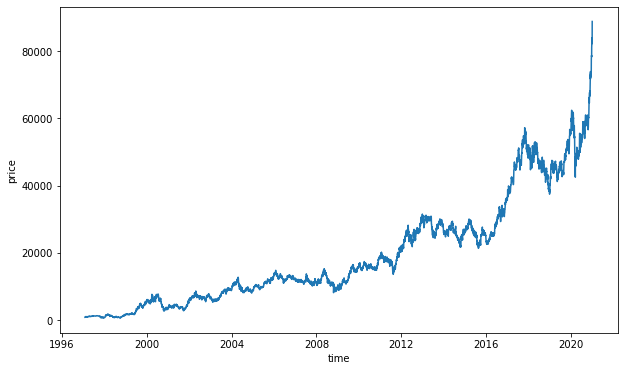

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

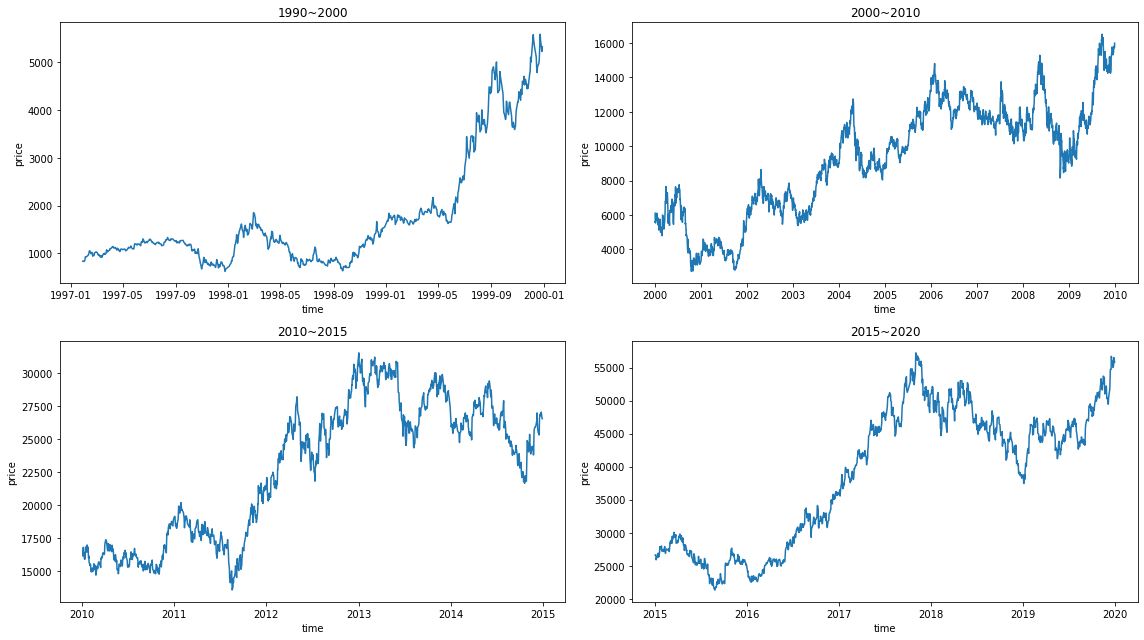

In [ ]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

### 2. Preprocessing

In [ ]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00990396, 0.00947778, 0.00980723, 0.00239302, 0.00305586],
       [0.01021609, 0.00945556, 0.00989157, 0.00239302, 0.00179584],
       [0.01009604, 0.00945556, 0.01008434, 0.00239302, 0.00195901],
       ...,
       [1.        , 0.93888889, 0.98915663, 0.92514715, 0.66291192],
       [0.9939976 , 0.93555556, 0.99638554, 0.93308609, 0.51416084],
       [1.        , 1.        , 1.        , 1.        , 0.90594483]])

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
# Train/Test Split

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

x_train.shape, y_train.shape

((4800, 4), (4800,))

In [ ]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.009904,0.009478,0.009807,0.003056
1,0.010216,0.009456,0.009892,0.001796
2,0.010096,0.009456,0.010084,0.001959
3,0.010048,0.009378,0.009867,0.000885
4,0.009988,0.009778,0.009964,0.002791
...,...,...,...,...
4795,0.277071,0.257778,0.275663,0.002885
4796,0.278031,0.262000,0.278795,0.002841
4797,0.283073,0.266889,0.281687,0.003876
4798,0.288836,0.267333,0.283855,0.003504


In [ ]:
# Window Methods

import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# Set parameters
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### 3. Modeling

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu', input_shape=[WINDOW_SIZE, 1]),
                                    tf.keras.layers.LSTM(16, activation='tanh'),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(1)])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
150/150 [==============================] - 10s 10ms/step - loss: 1.6257e-04 - mae: 0.0132 - val_loss: 0.0018 - val_mae: 0.0486

Epoch 00001: val_loss improved from inf to 0.00184, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0456e-05 - mae: 0.0033 - val_loss: 0.0014 - val_mae: 0.0410

Epoch 00002: val_loss improved from 0.00184 to 0.00145, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
150/150 [==============================] - 1s 7ms/step - loss: 9.6328e-06 - mae: 0.0031 - val_loss: 0.0018 - val_mae: 0.0467

Epoch 00003: val_loss did not improve from 0.00145
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 9.3485e-06 - mae: 0.0031 - val_loss: 0.0014 - val_mae: 0.0394

Epoch 00004: val_loss improved from 0.00145 to 0.00138, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
150/150 [==============================] - 1s 7ms/step - loss: 9.7523e-06 - mae: 0.0032 - val_loss: 0.0015 - v

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

(1180, 1)

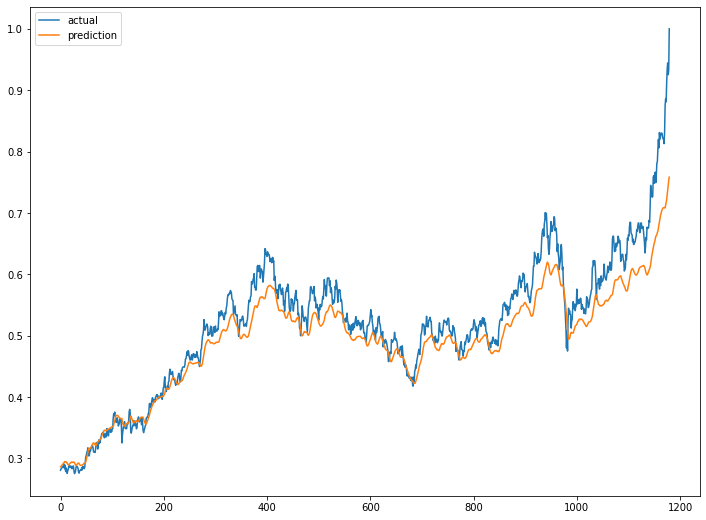

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

Reference: Samsung stock price prediction using LSTM and FinanceDataReader API, TeddyNotes [Available at https://teddylee777.github.io/]